# Hough Transforms

$E(x,y)$ represents edge points in your image - these are pixels that have been identified as being part of an edge (typically using something like a Sobel or Canny edge detector). Each point has image coordinates $(x,y)$.

$\theta$ (theta) is the angle from the x-axis to the normal of the line we're trying to detect, measured in degrees from 0 to 180. Think of it as "what angle might this line be at?".

$d$ (sometimes written as $\rho$ (rho)) represents the perpendicular distance from the origin to the line we're trying to detect. It can be negative or positive depending on which side of the origin the line falls.

$H[d,\theta]$ is the **accumulator array (sometimes called the Hough space)**. Each cell $H[d,\theta]$ counts how many edge points could be part of a line with those specific parameters

1. Initialize $H[d, \theta] = 0$
2. For each edge point in $E(x, y)$ in the image
3. For $d \in [0, 180]$
4. Compute $d = x\cos\theta - y\sin\theta$; keep in mind that this quantity may be negative
5. Set $H[d, \theta]$ += 1
6. Once you've done all that for all the degrees and for all edge points, find the values of $(d, \theta)$ where $H[d, \theta]$ has a high value.
7. Detected lines will be given by $d = x\cos\theta - y \sin\theta$

The unit vector in direction $\theta$ is $(\cos\theta, \sin\theta)$.
The point $(x,y)$ can be written as vector $\vec{r} = (x,y)$.
The projection length $d$ is the dot product: $\vec{r} \cdot (\cos\theta, \sin\theta)$.
This dot product: $d = x\cos\theta + y\sin\theta$.

But with images $y$ increases as we "go down".
Therefore, our final equation becomes $d = x\cos\theta - y\sin\theta$.

## References

- [wikipedia: Hough transform](https://en.wikipedia.org/wiki/Hough_transform)
- [medium: Implementing the Hough Transform from Scratch](https://medium.com/@alb.formaggio/implementing-the-hough-transform-from-scratch-09a56ba7316b)
  - https://github.com/AlbertoFormaggio1/Hough-Transform-From-Scratch

In [1]:
import cv2 as cv
from dataclasses import dataclass
from pathlib import Path
import requests
from tqdm.notebook import tqdm

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        headers = {'User-Agent': 'ComputerVisionExperiments/0.0 (https://github.com/seafoodfry/ml-workspace/tree/main/gpu-sandbox/vision)'}
        response = requests.get(self.url, headers=headers)
        response.raise_for_status()

        img_data = response.content
        with open(self.image_path, 'wb') as f:
            f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path, cv.IMREAD_UNCHANGED)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)


class ImageCache:
    def __init__(self, base_path: str = './img/005-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'park': ImageInfo( # https://www.gotokyo.org/en/see-and-do/attractions/parks-and-gardens/index.html
                image_path=self._base_path / 'park.jpg',
                url='https://www.gotokyo.org/en/see-and-do/attractions/parks-and-gardens/images/20_0104_1.jpg',
            )
        }
        for img_key, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]

    def cwd(self):
        return self._base_path


CACHE = ImageCache()

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_edge_points(img: cv.Mat, canny_threshold_1: int = 50, canny_threshold_2:int = 150):
    """
    Get edge points from an image using Canny edge detection.

    Docs:
    1. canny edge detection https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
    2. opencv docs https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de
    3. wiki https://en.wikipedia.org/wiki/Canny_edge_detector
    
    INPUTS
    ------
    img: Input image (grayscale or BGR)
        
    OUTPUTS
    -------
    edges: Binary image where 1 indicates edge points
    edge_points: List of (x,y) coordinates of edge points
    """
    # Convert to grayscale if needed.
    if len(img.shape) == 3:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img
        
    # Apply Canny edge detection.
    edges = cv.Canny(gray, canny_threshold_1, canny_threshold_2)
    
    # Get coordinates of edge points.
    edge_points = np.where(edges > 0)
    # Convert to (x,y) format.
    edge_points = list(zip(edge_points[1], edge_points[0]))  # Note: y,x to x,y conversion!
    
    return edges, edge_points


def hough_transform(edge_points, theta_steps=180, rho_max=None):
    """
    Implement Hough transform to detect lines.
    
    INPUTS
    ------
    edge_points: List of (x,y) coordinates of edge points
    theta_steps: Number of angle steps (default 180 for 1 degree steps)
    rho_max: Maximum distance from origin to consider (if None, computed from image size)
        
    OUTPUTS
    -------
    H: Accumulator array
    thetas: Array of theta values
    rhos: Array of rho values
    """
    # If rho_max not provided, compute from edge points.
    # This is used to initialize the accumulator array.
    if rho_max is None:
        max_x = max(p[0] for p in edge_points)
        max_y = max(p[1] for p in edge_points)
        rho_max = np.sqrt(max_x**2 + max_y**2)
    
    # Create theta and rho arrays.
    thetas = np.linspace(0, 180, theta_steps)
    rhos = np.linspace(-rho_max, rho_max, 2*int(rho_max))
    
    # Initialize accumulator array.
    H = np.zeros((len(rhos), len(thetas)))
    print(f'Size of H: {H.shape}')
    print(f'Number of elements: {H.size:_}')
    
    # Convert degrees to radians for numpy functions.
    thetas_rad = np.deg2rad(thetas)
    
    # For each edge point.
    for x, y in tqdm(edge_points, desc='Hough Transform: edge point iteration'):
        # For each theta.
        for theta_idx, theta in enumerate(thetas_rad):
            # Calculate rho.
            rho = x * np.cos(theta) - y * np.sin(theta)
            
            # Find the nearest rho bin.
            rho_idx = np.argmin(np.abs(rhos - rho))
            
            # Increment accumulator.
            H[rho_idx, theta_idx] += 1
    
    return H, thetas, rhos


def detect_lines(H, thetas, rhos, threshold=0.5):
    """
    Detect lines from Hough transform accumulator array.
    
    INPUTS
    -------
    H: Accumulator array
    thetas: Array of theta values
    rhos: Array of rho values
    threshold: Fraction of maximum accumulator value to consider as line
        
    OUTPUTS
    -------
    lines: List of (rho, theta) pairs representing detected lines
    """
    # Find peaks in accumulator array.
    H_max = H.max()
    peaks = np.where(H > threshold * H_max)
    
    # Convert peak indices to rho, theta values.
    lines = [(rhos[rho_idx], thetas[theta_idx]) 
             for rho_idx, theta_idx in zip(peaks[0], peaks[1])]
    
    return lines

In [4]:
"""
Contrast refers to the difference in brightness between adjacent pixels in an image.
High contrast means sharp transitions between dark and light areas.

Lower threshold (i.e., 50): Edges below this are rejected
Upper threshold (i.e., 150): Edges above this are definitely kept

The Canny thresholds work like this:

# High contrast image, strong edges
cv.Canny(img, 50, 150)

# Low contrast image, subtle edges
cv.Canny(img, 20, 60)

# Noisy image
cv.Canny(img, 100, 200)

Lower threshold (e.g. 50): Any edge with intensity gradient below this is discarded
Upper threshold (e.g. 150): Any edge with gradient above this is definitely kept
For gradients between thresholds: Only kept if connected to strong edges above upper threshold
"""
# Get edge points.
edges, edge_points = get_edge_points(CACHE['park'].img, canny_threshold_1=230, canny_threshold_2=250)

print(f'{len(edge_points):_}')

111_992


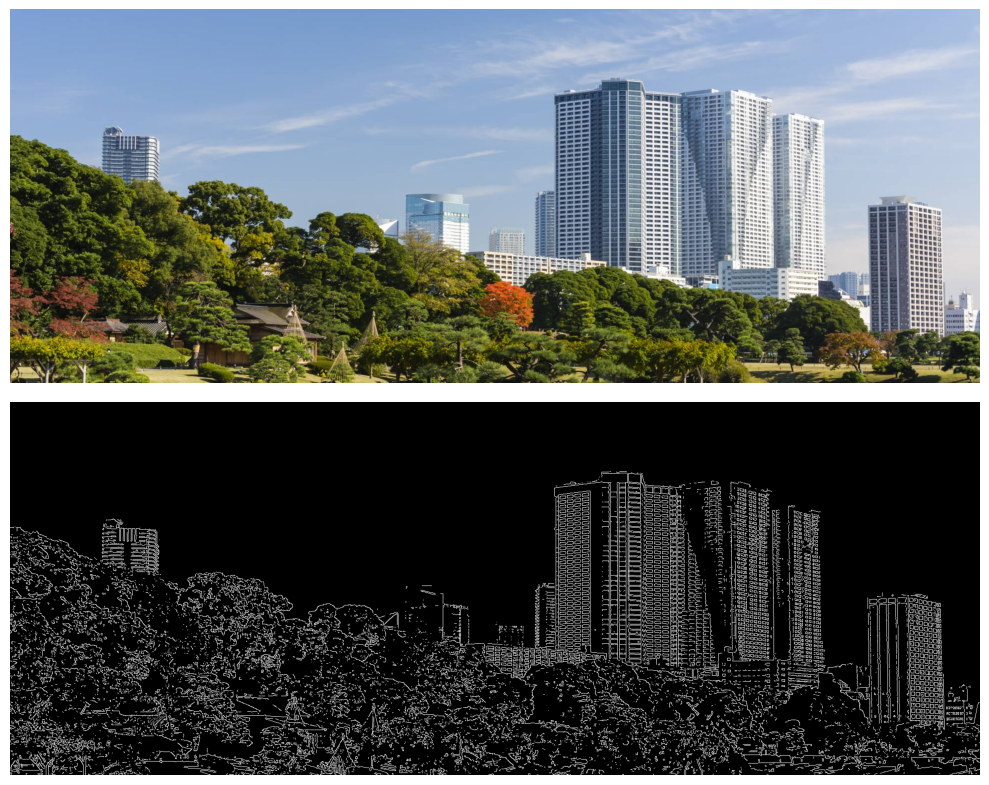

In [5]:
plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.imshow(CACHE['park'].rgb())
plt.axis('off')

plt.subplot(212)
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Apply Hough transform.
H, thetas, rhos = hough_transform(edge_points)

# Detect lines.
#lines = detect_lines(H, thetas, rhos, threshold=0.5)

Size of H: (4174, 180)
Number of elements: 751_320


Hough Transform: edge point iteration:   0%|          | 0/111992 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Hough Transform Space')

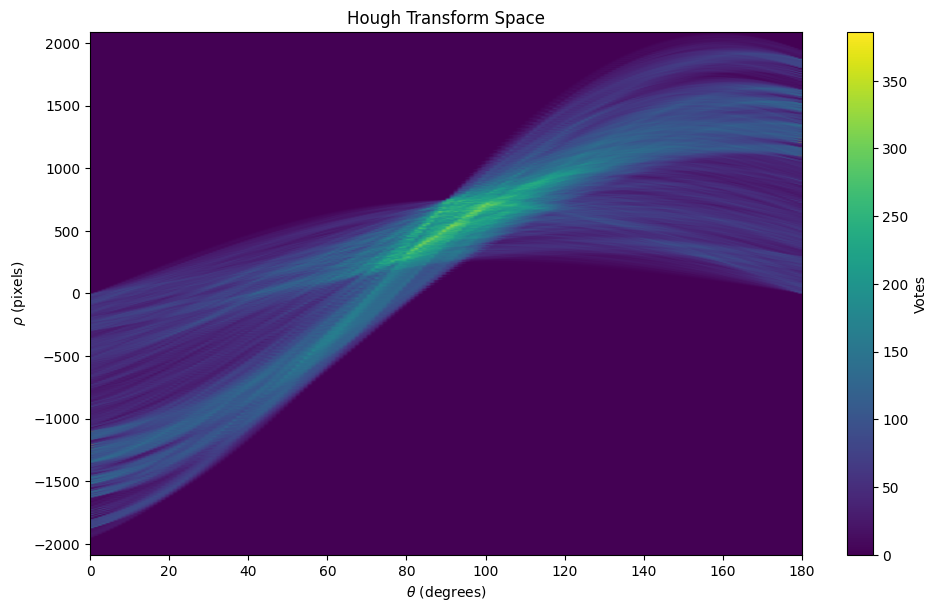

In [7]:
plt.figure(figsize=(10, 6))

plt.imshow(H, extent=[np.min(thetas), np.max(thetas), np.min(rhos), np.max(rhos)], aspect='auto', cmap='viridis')
plt.colorbar(label='Votes')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho$ (pixels)')

plt.tight_layout()
plt.title('Hough Transform Space')

Number of peaks found: ((134,), (134,))


Text(0.5, 1.0, 'Hough Transform Space')

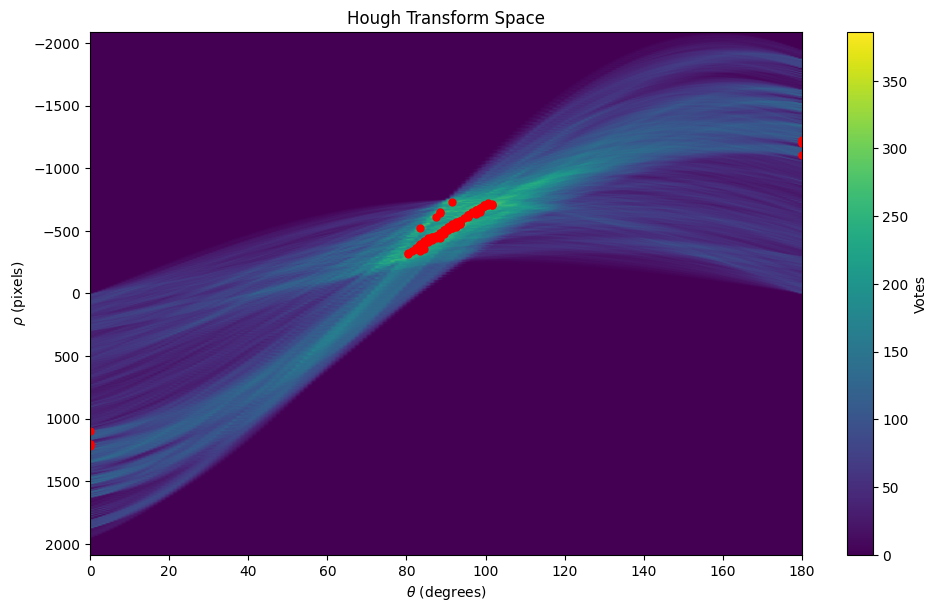

In [24]:
plt.figure(figsize=(10, 6))

# The underlying array indices have (0,0) at the top-left, but our plot shows (0,0) at center-left.
# Doing it like before will result in an inversion in the y-axis/rho values.
#plt.imshow(H, extent=[np.min(thetas), np.max(thetas), np.min(rhos), np.max(rhos)], aspect='auto', cmap='viridis')
plt.imshow(H, extent=[np.min(thetas), np.max(thetas), np.max(rhos), np.min(rhos)], aspect='auto', cmap='viridis')

# Get peaks.
threshold = 0.8
peaks = np.where(H > threshold * H.max())
print(f'Number of peaks found: {peaks[0].shape, peaks[1].shape}')

plt.plot(thetas[peaks[1]], rhos[peaks[0]], 'r.', markersize=10)
#mask = peaks[0] < len(rhos)//2  # Keep only positive rho values
#plt.plot(thetas[peaks[1][mask]], rhos[peaks[0][mask]], 'r.', markersize=10)

plt.colorbar(label='Votes')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho$ (pixels)')

plt.tight_layout()
plt.title('Hough Transform Space')

In [21]:
# Detect lines.
lines = detect_lines(H, thetas, rhos, threshold=0.6)

In [22]:
def draw_lines(img, lines):
    """
    Draw detected lines on an image.

    1. (x0,y0) is where line intersects normal from origin:
      x0 = d cos(θ), y0 = d sin(θ)
    2. Line direction is perpendicular to normal vector (cos(θ), sin(θ))
      So direction vector is (-sin(θ), cos(θ))
    3. Points on line are: (x0 \\pm t*sin(θ), y0 \\mp t*cos(θ))
      We use t=1000 to extend line across image
    
    INPUTS
    ------
    img: Original image
    lines: List of (rho, theta) pairs from detect_lines()
    
    OUTPUTS
    -------
    img_with_lines: Image with lines drawn
    """
    img_with_lines = img.copy()
    
    for rho, theta in lines:
        # Use the normal form of a line (\rho = x cos(θ) - y sin(θ)) to find points on each detected line
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = a * rho # \rho \cos\theta
        y0 = b * rho # \rho \sin\theta

        # The 1000 multiplier extends the line across the image by creating two distant points (x1,y1) and (x2,y2).
        # The number 1000 is chosen to be large enough to extend beyond typical image dimensions, creating what
        # appears to be an infinite line through (x0,y0) in the direction (a,b).
        x1 = int(x0 + 1000*(b)) # d\cos\theta + 1000\sin\theta OR x_0 + HIGH sin\theta
        y1 = int(y0 - 1000*(a)) # d\sin\theta - 1000\cos\theta OR y_0 - HIGH cos\theta
        x2 = int(x0 - 1000*(b)) # d\cos\theta - 1000\sin\theta OR x_0 - HIGH sin\theta
        y2 = int(y0 + 1000*(a)) # d\sin\theta + 1000\cos\theta OR y_0 + HIGH cos\theta
        
        cv.line(img_with_lines, (x1, y1), (x2, y2), (0,0,255), 2)
        
    return img_with_lines

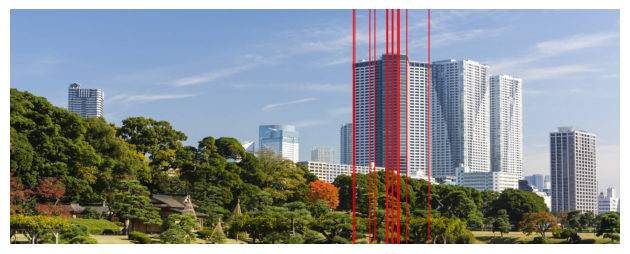

In [23]:
img_with_lines = draw_lines(CACHE['park'].img, lines)
img_with_lines_rgb = cv.cvtColor(img_with_lines, cv.COLOR_BGR2RGB)

plt.imshow(img_with_lines_rgb)
plt.axis('off')
plt.tight_layout()
plt.show()